### Members: Amitabh S Virk, Shehroz Sohail, Ajna R

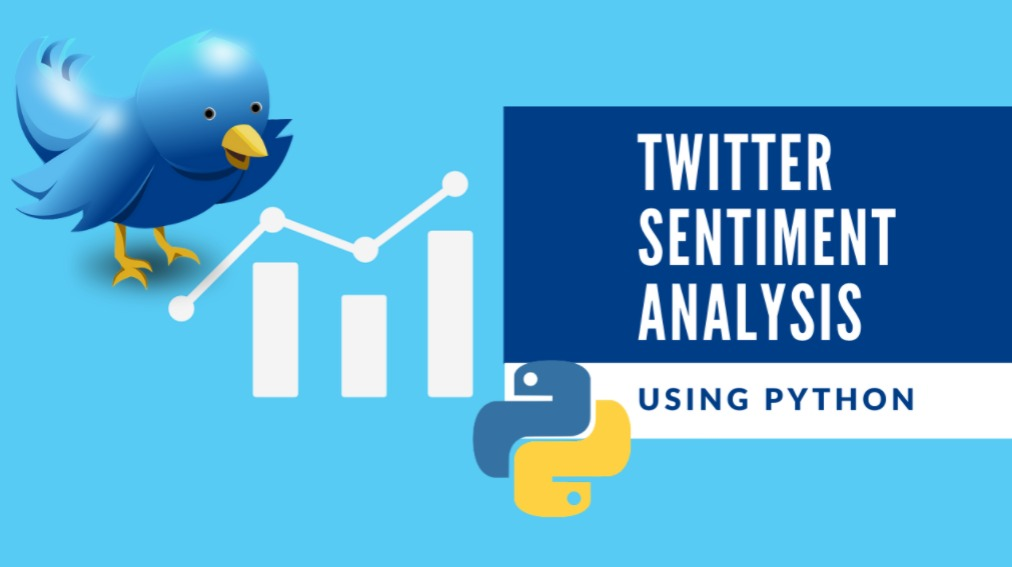

### **Rise of social media:**

The first line ever written for digital communication **“What hath god wrought”** stands as true today as it stood in 1844 when the telegram was discovered by **Samuel Morse**. The sheer expression of wonder and marvel can be felt by billions of people everyday when they pick their digital devices and start communicating. The rise in the internet has led to an exponential rise in **social media**. The term social media here means all the **social apps like whatsapp, facebook, instagram and twitter to name a few.** 


### **What this rise has given us:**

1. We feel closer than ever to our friends and family living even on the opposite sides of the globe.<br>
2. We feel updated of what’s happening in our environment more than ever.


Besides all the glory and benefits, there are a certain more aspects that have come into light recently. One of them being “ Freedom of Speech on social media” . This is one of the most debated topics recently and we don’t want to get into the nitty gritty details but this analysis is the result of the new direction freedom of speech on social media has taken. 


### **Context**
Twitter is one of the most influential social media sites out there. I remember once I read somewhere about twitter that explains the influence of twitter in normal people’s life very well  “that reading the tweets from the favorite celebrities feels like talking to them in real time.” 
There are **330 million monthly** active users and **145 million daily users** with a total of **1.3 billion accounts** in total. 22% of Americans are believed to be on twitter. These statistics explain how big twitter is. 

Now a very interesting figure is **83% of the total world’s politicians** are on twitter and **two of the top three influential  accounts are also political leader’s accounts.** 


### **Objective:**
**UOP analytics Inc** has been hired by twitter to analyze the tweets before the upcoming elections. It has been proven that social media is the key to winning the elections today, but the anonymity of social media can also take a very disturbance side when left unchecked. Twitter wants us to run the **Sentiment Analysis** on the recent tweets and get a sense of the sentiments displayed by the supporters and candidates of the US elections. Based on this analysis twitter can draw a strategy to flag the tweets with negative polarity or negative sentiment. This analysis will also be used to find the accounts which are violating tweeter’s policies regarding tweet violence. 


### **Data**
1. For tweets data we are using kaggle’s “US Election 2020 Tweets”. 

2. It contains two files with tweets having #donaldtrump and #joebiden. 


3. Each file has further 21 columns of data like date and time of the tweet, tweet id, tweet, Number of likes, retweet_count, source, user id, user_name, user description , location, city, country, state etc.


### **What are we trying to achieve:**
**1. What are the overall sentiments of the tweets regarding elections**<br>
**2. Clusters of tweets based on polarity of the tweets. Negative, Positive and Neutral.**<br>
**3. Locations with most profound sentiments or based on the clusters**<br>
**4. Identify users with most negative and positive tweets towards each candidate and locations if possible**<br>
**5. Some recommendations on what to be done if the tweet or a user is flagged by the model?**


# Analysis

In [1]:
import pandas as pd
import numpy as np


import re
import string

#NLTK
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

#Date-time
from datetime import datetime
import dateutil.parser as dparser


In [5]:
trump_raw = pd.read_csv("D:\Codes\PROJECT 2\hashtag_donaldtrump.csv",
                 lineterminator='\n')

biden_raw = pd.read_csv("D:\Codes\PROJECT 2\hashtag_joebiden.csv",
                 lineterminator='\n')

#trump_raw = pd.read_csv("C:/Users/ariver10/Downloads/archive/hashtag_donaldtrump.csv",
#                 lineterminator='\n')

#biden_raw = pd.read_csv("C:/Users/ariver10/Downloads/archive/hashtag_joebiden.csv",
#                 lineterminator='\n')

In [6]:
#Removes columns of data with very high Na values. 
trump=trump_raw.drop(['user_description','long','lat','city','continent',
'state','state_code'], axis=1)

#remove rows of data with less NaN values
trump=trump.dropna(subset=['user_name','source','user_location'])

print(f"This data has (rows x col){trump.shape}")
print(f"total NaN values in this dataFrame: {trump.isna().sum().sum()}")


This data has (rows x col)(675765, 14)
total NaN values in this dataFrame: 233165


In [7]:
#Removes columns of data with very high Na values. 
biden=biden_raw.drop(['user_description','long','lat','city','continent',
'state','state_code'], axis=1)

#remove rows of data with less NaN values
biden=biden.dropna(subset=['user_name','source','user_location'])

print(f"This data has (rows x col){biden.shape}")
print(f"total NaN values in this dataFrame: {biden.isna().sum().sum()}")

This data has (rows x col)(542952, 14)
total NaN values in this dataFrame: 189262


In [8]:
#Add ac column of T and a column of B in trump and biden respectively to easily be able to identify them
trump['candidate']='T'
biden['candidate']='B'

In [9]:
trump['user_location'].head()

0    Philadelphia, PA / Miami, FL
2                        Portland
4                   Washington DC
5               Perris,California
6                      Powell, TN
Name: user_location, dtype: object

In [10]:
#CHECK OVER THIS FOR DATASETS WE DON'T NEED
trump_raw['both'] = trump_raw.tweet_id.isin(biden_raw.tweet_id).astype(int) #makes column for both candidates hashtagged
biden_raw['both'] = trump_raw.tweet_id.isin(biden_raw.tweet_id).astype(int)
trump_raw['hash'] = np.where((trump_raw['both'] == 0), 'Trump', 'Both') #makes categorical column 
biden_raw['hash'] = np.where((biden_raw['both'] == 0), 'Biden', 'Both')

full_df = trump_raw.append(biden_raw) #shape = (1522909, 21) #appends datasets together

tweets_loc = trump.append(biden) #adds trump and biden hashtag data into a single dataframe shape = (1747805, 21)

tweets_loc = tweets_loc.drop_duplicates(subset = 'tweet_id') #drops overlapping tweets (hashtag for both Trump and Biden) shape = (1522909, 21)

US = tweets_loc['country'] == 'United States of America' #selects only USA tweets

tweets_USA = tweets_loc[US] #shape = (301341, 21)


tweets_loc=tweets_loc.drop(['country'], axis=1).reset_index() #drops extra columns we wont use shape = (301341, 10)
tweets_USA=tweets_USA.drop(['country'], axis=1).reset_index()

The following makes the location-specific dataset.  This will be combined with sentiment analysis at the end. For now it is a pared down dataset of the tweets in the US only. This dataset is called locData_df

In [11]:
#START HERE for location set makes new dataset with locations (only for tweets with location data)
#This specifically makes a dataset that can be use for geolocation and categorizing based on Trump vs. Biden hashtag
trump_raw['both'] = trump_raw.tweet_id.isin(biden_raw.tweet_id).astype(int) #makes column for both candidates hashtagged
biden_raw['both'] = trump_raw.tweet_id.isin(biden_raw.tweet_id).astype(int)
trump_raw['hash'] = np.where((trump_raw['both'] == 0), 'Trump', 'Both') #makes categorical column 
biden_raw['hash'] = np.where((biden_raw['both'] == 0), 'Biden', 'Both')
full_df = trump_raw.append(biden_raw) #shape = (1522909, 21) #appends datasets together
locData_df = full_df.drop_duplicates(subset = 'tweet_id') #drops overlapping tweets (hashtag for both Trump and Biden) shape = (1522909, 21)
US = locData_df['country'] == 'United States of America' #selects only USA tweets
locData_df = locData_df[US] #shape = (301341, 21)
locData_df=locData_df.drop(['user_description','user_location','user_name', 'user_screen_name','source','city','country','continent',
 'collected_at', 'both'], axis=1) #drops extra columns we wont use shape = (301341, 10)
locData_df = locData_df.reset_index()

## Pre processing the tweets

In [13]:
processed = pd.read_csv("D:\Codes\PROJECT 2\processed\processed.csv")
processed_USA=pd.read_csv("D:\Codes\PROJECT 2\processed\processed_usa.csv")
processed_USA.dtypes

Unnamed: 0     int64
0             object
dtype: object

### ATTENTION: (This cell creates the processed.csv file. If you have the processed.csv file imported you donot need to run this part of the notebook. let it stay as a markdown cell)

def process_tweet(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean
    
### Applying the above made function on all of the data set. (This is a very resource intensive task. Run at your own risk)

x={}    # Inititalizing a new dictionary to store the values in
i=0     # A seperate iterator to avoid a double for loop
for tweet in tweets_USA['tweet']:
    x[i]=process_tweet(tweet)
    i+=1

s = pd.Series(x)

type(s)

s.to_csv(r"D:\Codes\PROJECT 2\processed_usa.csv")

## Adaptation
1) countdown to election column <br>
2) age of account column (looking for increase in bots close to the election)

Make a new column based on time until the election. Negative numbers are "countdown" until the election, positive numbers are days after the election

In [14]:
#converts created_at to a numerical value of time until the election
from datetime import datetime
import dateutil.parser as dparser
created_at = locData_df['created_at']
countdown = []
for i in range(len(created_at)):
    time = dparser.parse(created_at[i])
    election = datetime(2020, 11, 3)
    newtime = (time - election).days
    countdown.append(newtime)
locData_df['countdown'] = countdown

Creates a column for age of user - we will look to see if "bots" created new accounts in the days just before or after the election. 
This also drops the old timestamp columns

In [15]:
joined = locData_df['user_join_date']
account = locData_df['created_at']
agelist = []
for i in range(len(joined)):
    time = dparser.parse(joined[i])
    created = dparser.parse(account[i])
    newtime = (created-time).days
    agelist.append(newtime)
locData_df['age'] = agelist
locData_df = locData_df.drop(['created_at', 'index', 'user_join_date'], axis = 1)

In [16]:
locData_df.head()

,tweet_id,tweet,likes,retweet_count,user_id,user_followers_count,lat,long,state,state_code,hash,countdown,age
0,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,3.606665e+08,1860.0,25.774270,-80.193660,Florida,FL,Both,-19,3340
1,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,8.436472e+06,1185.0,45.520247,-122.674195,Oregon,OR,Trump,-19,4798
2,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,4.741380e+07,5393.0,38.894992,-77.036558,District of Columbia,DC,Trump,-19,4139
3,1.316529e+18,@CLady62 Her 15 minutes were over long time ag...,2.0,0.0,1.138416e+09,2363.0,33.782519,-117.228648,California,CA,Trump,-19,2812
4,1.316529e+18,@DeeviousDenise @realDonaldTrump @nypost There...,0.0,0.0,9.007611e+17,766.0,40.225357,-82.688140,Ohio,OH,Trump,-19,1147


## Visualization
We created 4 types of graphs to visualize how the data interacts. <br>
1. Correlation analysis over our primary numerical data
2. Scatterplot comparing likes and retweets by hashtag
3. 2 maps looking at average likes/state over time for #Biden and #Trump
4. Line graphs examining changes in tweeting behavior over time

In [17]:
import plotly
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px

In a simple correlation heat map, we see that the pre-analysis dataset of tweets in from the US have a higher correlation between "likes" and "retweets," which is not surprising since retweets help get likes and liked tweets are often retweeted. <br>
We also see a weak positive correlation between both of these metrics and follower count.  That is, the more popular tweets you have, the more popular you are as a tweeter. The weakness of this correlation is somewhat surprising, given the strength of correlation between likes and retweets, and suggests that Twitter is more democratic than we suspected. 

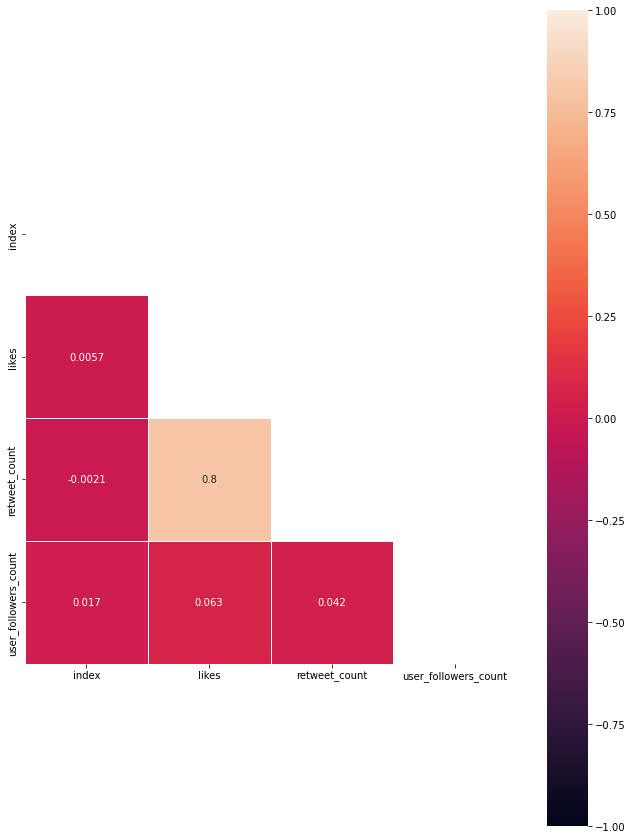

In [18]:
correlations = tweets_loc.copy()
correlations = correlations.drop(['tweet', 'user_id', 'tweet_id'], axis = 1)
corr_matrix = correlations.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)]= True
mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      vmin = -1,
                      vmax = 1,
                      annot = True)


A correlation plot between numbers of retweets and likes bears out what we see in the above analysis.  Tweets are color coded by candidate hashtag, there is no obvious clustering of color codes suggesting that #Trump and #Biden tweets have similar variability in likes and retweets. 

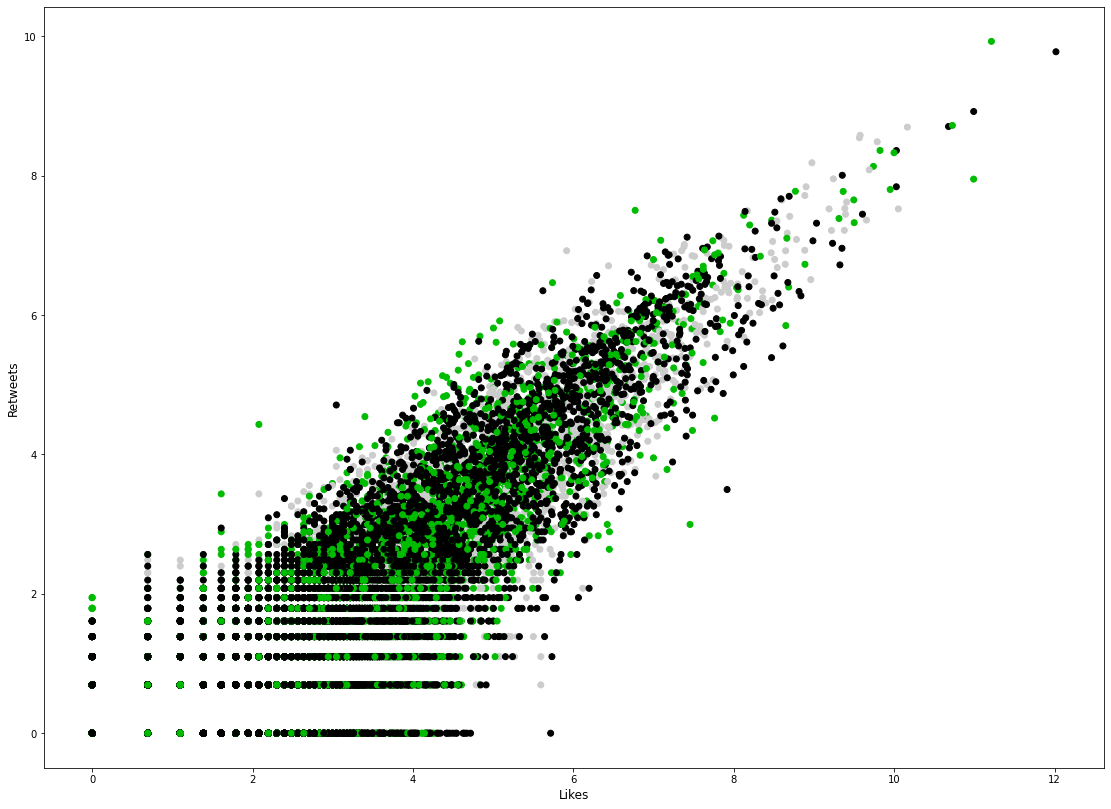

In [33]:
locData_df.hash.astype('category').cat.codes
plt.scatter(x=np.log(locData_df.likes),
            y=np.log(locData_df.retweet_count),
            c=locData_df.hash.astype('category').cat.codes,
           cmap = 'nipy_spectral')
plt.xlabel("Likes", size=12)
plt.ylabel("Retweets", size=12)
plt.rcParams['figure.figsize']=[19,14]


The following map maps the average number of likes each #Biden tweet got in each state in the days leading up to and directly after the election. <br>
On election day, West Coast, NorthEast, and Southern states had more "likes" per #Biden tweet.<br>
After the election, more states had high average likes for #Biden tweets, perhaps suggesting more engagement on Twitter with this hashtag


In [34]:
Biden = locData_df['hash']=="Biden"
tweets_biden = locData_df[Biden]
map = tweets_biden.groupby(["state_code", "countdown"],  as_index=False)["likes"].mean()
px.choropleth(map, 
              locations = 'state_code',
              color="likes", 
              animation_frame="countdown",
              color_continuous_scale="Inferno",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 10),
              title='Likes per Biden tweet',
              height=600
             )

The following map shows the average number of likes each #Trump tweet got in each state in the days leading up to and directly after the election. <br>
Trump tweets did not appear to do as well on average as Biden tweets, at least aggregated by state. <br>
On election day, a similar pattern is seen in average likes for #Trump tweets as #Biden tweets

In [35]:
Trump = locData_df['hash']=="Trump"
tweets_trump = locData_df[Trump]
maptrump = tweets_trump.groupby(["state_code", "countdown"],  as_index=False)["likes"].mean()
px.choropleth(maptrump, 
              locations = 'state_code',
              color="likes", 
              animation_frame="countdown",
              color_continuous_scale="Inferno",
              locationmode='USA-states',
              scope="usa",
              range_color=(0, 10),
              title='Likes per Trump tweet',
              height=600
             )

The following two cells compare overall state average for likes of #Trump vs #Biden tweets. <br>
Overall both hashtags followed similar temporal patterns.  #Trump tweets got fewer likes on average, but had a much higher like level. 

In [36]:
map.describe() # #Biden

,countdown,likes
count,1297.000000,1297.000000
mean,-7.006168,6.614728
std,7.222326,23.729872
min,-19.000000,0.000000
25%,-13.000000,0.828947
50%,-7.000000,1.894737
75%,-1.000000,4.590909
max,5.000000,543.809524


In [37]:
maptrump.describe() # #Trump

,countdown,likes
count,1299.000000,1299.000000
mean,-6.983064,3.913043
std,7.214180,8.730824
min,-19.000000,0.000000
25%,-13.000000,0.733440
50%,-7.000000,1.453416
75%,-1.000000,3.061625
max,5.000000,117.400000


The following graph shows the averages for likes, retweets, and age of account per day before and after the election. <br>
Unexpectedly, there was no spike in new accounts by bots just before the election. Retweet levels seem fairly steady, but likes spiked about 18 days before the election and had a more erratic pattern. 

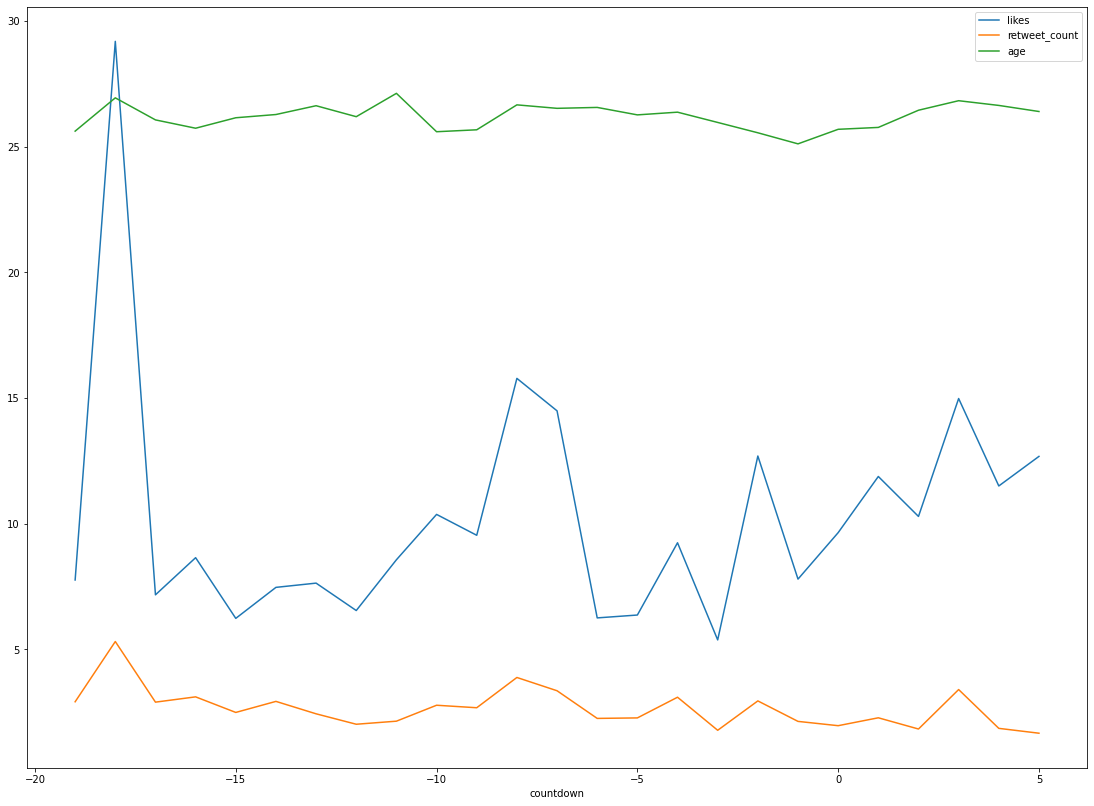

In [43]:
by_day = locData_df.groupby(["countdown"])
day_means = by_day.mean()
day_means['age'] = day_means['age']/100
day_means_summary = day_means[['likes', 'retweet_count', 'age']]
day_means_summary.plot().figsize=(8,14)